# Example Analysis
This is an example analysis to showcase the functionality of the Python wrapper for the Database of Religious History (DRH) API. We will curate a small dataset to investigate the relationship between internal and external conflict (predictors) and permanent scarring or painful bodily alterations (outcome). Then we will run simple analysis on this data and visualize temporal and regional effects. The analysis is inspired by Sosis et al. (2007)

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from drhwrapper import DRHWrapper

drh = DRHWrapper("religiondatabase.org/public-api")

## 1. Curate Data
We will start by defining and requesting the relevant variables through the API for the Database of Religious History (DRH).

In [2]:
# all the relevant question names
# can be found by browsing: https://religiondatabase.org/
question_names = [
    "Are other religious groups in cultural contact with target religion:",
    "Is there violent conflict (within sample region):",
    "Is there violent conflict (with groups outside the sample region):",
    "Does membership in this religious group require permanent scarring or painful bodily alterations:",
]

In [3]:
# for each of these questions get the answersets
# this will take a minute or two
answerset_list = []
for question_name in question_names:
    answerset = drh.get_answerset(question_name=question_name, to_dataframe=True)
    answerset["question_name"] = question_name
    answerset_list.append(answerset)

# concatenate the answersets
answerset_df = pd.concat(answerset_list)

Attempt 1 failed with error: Expecting value: line 1 column 1 (char 0)
Retrying in 1.02 seconds...


In [4]:
# only take religious groups
answerset_df["poll_name"].unique()  # have both group and place polls
answerset_groups = answerset_df[answerset_df["poll_name"].str.contains("Group")]


In [5]:
# different question ID for corresponding questions
# for Group V5 and Group V6 Questions
# can use the .get_related_questions() method
# (although in this case this is not strictly necessary)
related_questions = drh.get_related_questions()
answerset_groups["related_question_id"] = answerset_groups["question_id"].map(
    related_questions.set_index("question_id")["related_question_id"]
)
answerset_groups = answerset_groups.drop(columns=["question_id"])
answerset_groups = answerset_groups.rename(
    columns={"related_question_id": "question_id"}
)

In [6]:
# select only yes/no answers
# answer_value more accurate than answer_name
# because sometimes answer_name will be a non-English character
answerset_groups = answerset_groups[answerset_groups["answer_value"].isin([0, 1])]


### select only consistent answers

Possible to multiple answers for one religious group to one question.
This can happen for the following reasons: 
1) different time periods
2) different regions
3) different subgroups (e.g., elite, common)
4) different experts
5) scholarly disagreement or flexibility in religious beliefs/practices
Here we will only take cases that have a single consistent answer.


In [7]:
# we need to do this because around 50% of the cases
# where we have multiple answers to the same question
# for the same religious group, the answers are the same
# (e.g., "Yes" and "Yes") but sometimes for different
# time periods, regions, or sub-groups.
answerset_simple = answerset_groups[
    [
        "entry_id",
        "entry_name",
        "poll_name",
        "answer_value",
        "question_id",
        "question_name",
    ]
].drop_duplicates()

In [8]:
# now find the cases where we have inconsistent answers
groups_answers = (
    answerset_simple.groupby(["entry_id", "question_id"])
    .size()
    .reset_index(name="count")
)
inconsistent_answers = groups_answers[groups_answers["count"] > 1][
    ["entry_id", "question_id"]
].reset_index(drop=True)

# print the number of cases with inconsistent answers
print(
    f"n={len(inconsistent_answers)} cases with inconsistent answers out of n={len(answerset_simple)} total answers"
)

n=14 cases with inconsistent answers out of n=2790 total answers


Example of case where we have inconsistent answers:  
Late Choson Korea (Entry ID: 228) has a "Yes" for the question
"Are other religious groups in cultural contact with target religion:"
for "Elite" but a "No" answer for "Non-elite (common people, general populace)".

When we observe inconsistency for the super-question (the one above)
we will also remove the sub-questions for the religious group in question
In this case these are: 
1) "Is there violent conflict (within sample region):"
2) "Is there violent conflict (with groups outside the sample region):"

In [9]:
# flag sub-questions for inconsistent super-questions
superquestion = 2316  # cultural contact
subquestions = [2256, 2305]  # internal and external conflict
new_rows = []
for index, row in inconsistent_answers.iterrows():
    entry_id = row["entry_id"]
    question_id = row["question_id"]
    if question_id == superquestion:
        new_rows.append({"entry_id": entry_id, "question_id": subquestions[0]})
        new_rows.append({"entry_id": entry_id, "question_id": subquestions[1]})
df_new_rows = pd.DataFrame(new_rows)
inconsistent_answers = pd.concat([inconsistent_answers, df_new_rows]).reset_index(
    drop=True
)

# print updated number of cases with inconsistent answers
print(
    f"n={len(inconsistent_answers)} cases with inconsistent answers out of n={len(answerset_simple)} total answers"
)

n=20 cases with inconsistent answers out of n=2790 total answers


In [10]:
# now remove the inconsistent answers
answerset_simple = answerset_simple[
    ~answerset_simple.set_index(["entry_id", "question_id"]).index.isin(
        inconsistent_answers.set_index(["entry_id", "question_id"]).index
    )
]

### Infer answers for sub-questions

If answer to "cultural contact" is "No" then we can infor that the answer to the 2 sub-questions is also "No". In this case the sub-questions are: 
1) "Is there violent conflict (within sample region):"
2) "Is there violent conflict (with groups outside the sample region):"

The trick is that if the answer to the super-question is not "Yes" then there will not be a row for the sub-question (no answer). We have to add this row. 

In [11]:
answerset_inferred = answerset_simple.copy()
answerset_inferred["answer_inferred"] = "No"
question_names = answerset_inferred.set_index("question_id")["question_name"].to_dict()

inferred_rows = []
for num, row in answerset_inferred.iterrows():
    # only (potentially) infer values if super-question is answered "No"
    if (row["question_id"] == superquestion) & (row["answer_value"] == 0):
        # if the answer to the super-question is "No"
        # there will not be an answer to the sub-questions
        # so we can assume that these are missing and should be inferred
        for subquestion in subquestions:
            question_name = question_names[subquestion]
            inferred_rows.append(
                {
                    "entry_id": entry_id,
                    "entry_name": row["entry_name"],
                    "poll_name": row["poll_name"],
                    "answer_value": 0,
                    "question_id": subquestion,
                    "question_name": question_name,
                    "answer_inferred": "Yes",
                }
            )

inferred_df = pd.DataFrame(inferred_rows)
print(f"n={len(inferred_df)} inferred answers")  

# add the inferred answers to the dataset
answerset_inferred = pd.concat([answerset_inferred, inferred_df]).reset_index(drop=True)

n=46 inferred answers


## 2. Analyze Data

Following Sosis et al. (2007) we need: 
- external conflict (we already have this)
- internal conflict **only** (we need to code this)

In [12]:
# assign shorthands for the question names (for convenience)
questions_short = {
    2316: "Cultural Contact",
    3122: "Permanent Scarring or Painful Bodily Alterations",
    2305: "External Violent Conflict",
    2256: "Internal Violent Conflict",
}
answerset_inferred["question_short"] = answerset_inferred["question_id"].map(
    questions_short
)

In [13]:
# expand dataset to code internal conflict
answerset_expanded = answerset_inferred.pivot(
    index=["entry_id", "entry_name"],
    columns="question_short",
    values="answer_value",
).reset_index()

In [14]:
# code internal conflict
answerset_expanded["Internal Conflict Only"] = np.where(
    # if any is nan then the result is nan
    (answerset_expanded["Internal Violent Conflict"].isna())
    | (answerset_expanded["External Violent Conflict"].isna()),
    np.nan,
    # else if internal conflict is 1 and external conflict is 0
    np.where(
        (answerset_expanded["Internal Violent Conflict"] == 1)
        & (answerset_expanded["External Violent Conflict"] == 0),
        1,
        0,
    ),
)

In [15]:
# now we can run simple analysis
from scipy.stats import chi2_contingency


def calc_chi2(answerset, outcome, predictor):
    contingency = pd.crosstab(answerset[outcome], answerset[predictor])
    chi2, p, _, _ = chi2_contingency(contingency)
    return chi2, p

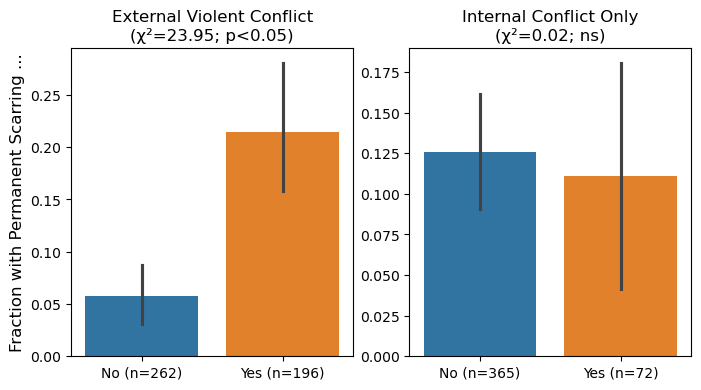

In [16]:
# plot the results
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
outcome = "Permanent Scarring or Painful Bodily Alterations"
predictors = ["External Violent Conflict", "Internal Conflict Only"]
palette = sns.color_palette("tab10", n_colors=2)
for num, predictor in enumerate(predictors):
    # drop missing values
    df_subset = answerset_expanded[[outcome, predictor]].dropna()
    df_subset = df_subset.sort_values(predictor)
    group_counts = df_subset.groupby(predictor).size()

    # run chi2 test
    chi2, p = calc_chi2(df_subset, outcome, predictor)
    chi2_label = f"χ²={chi2:.2f}; p<0.05" if p < 0.05 else f"χ²={chi2:.2f}; ns"

    # plot
    sns.barplot(
        x=predictor,
        y=outcome,
        data=df_subset,
        ax=ax[num],
        hue=predictor,
        palette=palette,
    )
    ax[num].set_xlabel("")
    ax[num].set_xticks([0, 1])
    ax[num].set_xticklabels(
        [f"{value} (n={n})" for value, n in zip(["No", "Yes"], group_counts)]
    )
    ax[num].set_title(f"{predictor}\n({chi2_label})")
    # only label the first plot
    if num == 0:
        ax[num].set_ylabel("Fraction with Permanent Scarring ...", fontsize=12)
    else:
        ax[num].set_ylabel("")
    ax[num].legend().remove()

## 3. Temporal Analysis
We now focus only on "External Violent Conflict" and "Permanent Scarring or Painful Bodily Alterations". 

In [17]:
# select only the relevant columns and drop nan.
external_conflict = answerset_expanded[
    [
        "entry_id",
        "entry_name",
        "External Violent Conflict",
        "Permanent Scarring or Painful Bodily Alterations",
    ]
].dropna()

In [18]:
# merge in temporal information
temporal_information = answerset_groups[
    ["entry_id", "year_from", "year_to"]
].drop_duplicates()

external_conflict_temporal = external_conflict.merge(
    temporal_information, on="entry_id", how="inner"
)

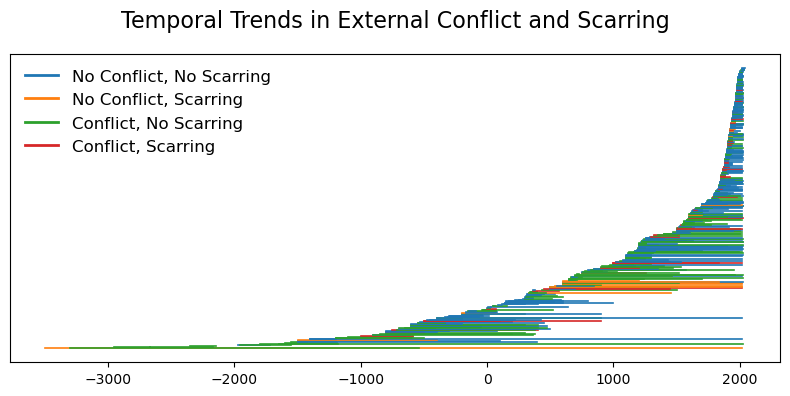

In [19]:
# plot the temporal trend
external_conflict_temporal = external_conflict_temporal.sort_values(
    "year_from"
).reset_index(drop=True)

# define color mapping
color_map = {
    (0, 0): "tab:blue",  # no conflict, no scarring
    (0, 1): "tab:orange",  # no conflict, scarring
    (1, 0): "tab:green",  # conflict, no scarring
    (1, 1): "tab:red",  # conflict, scarring
}

# Plot setup
fig, ax = plt.subplots(figsize=(8, 4))

# Create evenly spaced y-values for the lines
y_values = range(len(external_conflict_temporal))

# Plot each line using y_values for the y-coordinate
for y, row in external_conflict_temporal.iterrows():
    # Determine the color based on the combination of the two columns
    conflict = row["External Violent Conflict"]
    scarring = row["Permanent Scarring or Painful Bodily Alterations"]
    color = color_map[(conflict, scarring)]

    # Set year_to to year_from + 20 if the difference is less than 20 years
    year_to = row.year_to if (row.year_to - row.year_from) >= 20 else row.year_from + 20

    # Plot the line with the corresponding color
    ax.plot(
        [row.year_from, year_to],
        [y, y],
        color=color,
        linewidth=1.2,
    )

# Remove y ticks and labels as they are not relevant
ax.set_yticks([])
ax.set_yticklabels([])

# Create a custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="tab:blue", lw=2, label="No Conflict, No Scarring"),
    Line2D([0], [0], color="tab:orange", lw=2, label="No Conflict, Scarring"),
    Line2D([0], [0], color="tab:green", lw=2, label="Conflict, No Scarring"),
    Line2D([0], [0], color="tab:red", lw=2, label="Conflict, Scarring"),
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc="upper left", fontsize=12, frameon=False)

# Show the plot
plt.suptitle("Temporal Trends in External Conflict and Scarring", fontsize=16)
plt.tight_layout()
plt.show()

There is definitely an overweight of more recent religious groups in this analysis (and more generally in the DRH). It is not entirely clear from this figure whether there is a temporal trend in the variables (would need another kind of visualization--or statistical analysis--to really tell).

## Spatial Analysis

In [41]:
# we need .list_regions to obtain the raw geom objects
entry_regions = drh.list_regions(to_dataframe=True, limit=2000)
entry_regions = entry_regions[["region_id", "geom"]]
spatial_information = answerset_groups[["entry_id", "region_id"]].drop_duplicates()
spatial_information = spatial_information.merge(
    entry_regions, on="region_id", how="inner"
)
# merge on to the external conflict dataset
external_conflict_spatial = external_conflict.merge(spatial_information, on = 'entry_id', how = 'inner')

In [79]:
# Function to convert nested lists to Polygon
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
# Function to convert nested lists to Polygon using Shapely 2.0
def convert_to_polygon(nested_list):
    # Adjust the indexing based on your actual data structure
    if nested_list:
        outer_list = nested_list[0][0]  # Extract the first list of coordinates
        return Polygon(outer_list)
    return None

# Convert the 'geom' data to Shapely polygons
external_conflict_spatial['geometry'] = external_conflict_spatial['geom'].apply(convert_to_polygon)

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(external_conflict_spatial, geometry='geometry')

In [82]:
# we will want to exclude the global regions because they obstruct
# calculate the area of the regions
gdf = gdf.set_crs("EPSG:4326")
gdf['area'] = gdf['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**6)
gdf = gdf[gdf['area'] < 20000000] # world is around 510 million km²

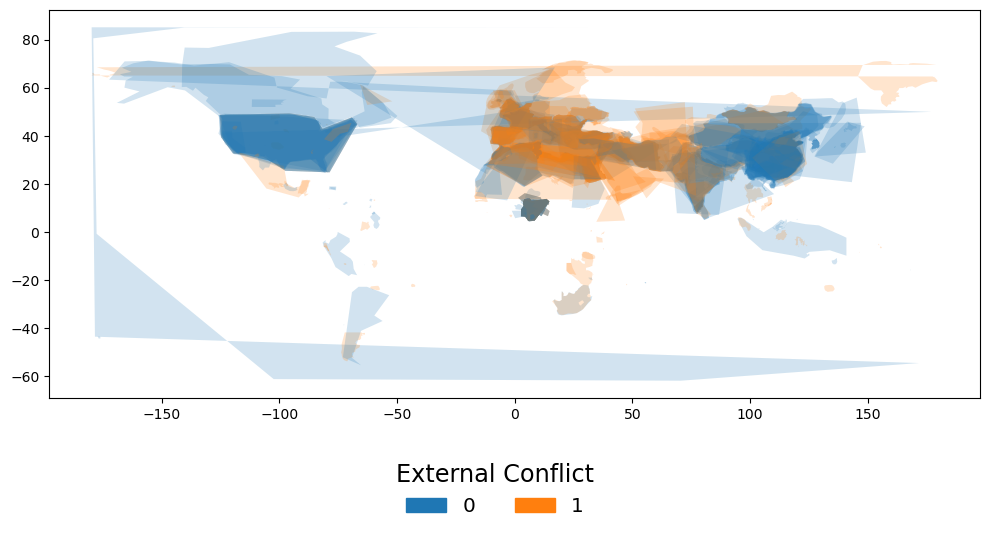

In [98]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create a colormap for the unique poll names
conflict_names = [0, 1]
colors = plt.get_cmap('tab10')  # Correct colormap fetching
color_dict = {name: colors(i) for i, name in enumerate(conflict_names)}

# Create a figure and axes manually
fig, ax = plt.subplots(figsize=(10, 5.5))

# Plot the GeoDataFrame
gdf.plot(ax=ax, color=[color_dict[name] for name in gdf['External Violent Conflict']], alpha=0.2)

# Create a legend for the whole figure
handles = [Patch(color=color_dict[name], label=name) for name in conflict_names]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(conflict_names),
           title='External Conflict', title_fontsize='xx-large', fontsize='x-large', frameon=False)

# Display the plot
plt.tight_layout()
plt.show()

Some polygons cross the antimeridian which makes this visualization less appealing. However, we can see that there is good coverage in Europe and Asia, and that coverage in Africa (besides north Africa) and South America is less strong. It also looks like there are lower rates of external violent conflict in parts of Asia (China) and in North America.